In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
import os
import inspect
import datetime
np.random.seed(seed=1994)

font = {'size'   : 12}

plt.rc('font', **font)

In [2]:
#Download data with PDR
end = datetime.datetime.today()
start = datetime.datetime(year=end.year-10, month=end.month, day=end.day)

#Fred as standard API
symbols = ["T5YIE","T10YIE"]
fred = pdr.DataReader(symbols, 'fred', start, end)
symbols = ["PCEPI"]
pcepi_index = pdr.DataReader(symbols, 'fred', start, end)
pcepi_index.index = pcepi_index.index + pd.offsets.MonthEnd(0)+pd.offsets.BusinessDay(n = 20)
fred = pd.concat([fred, pcepi_index], axis = 1)
fred.to_csv("fred.csv")

fred = pd.read_csv("fred.csv", index_col = "DATE")

#Cleanse Data
fred.index = pd.DatetimeIndex(fred.index)
fred[["T5YIE","T10YIE"]] = fred[["T5YIE","T10YIE"]].interpolate(method = "linear")
fred = fred.dropna()
print("Last data point for:" +str(fred.index[-1]))


Last data point for:2022-01-28 00:00:00


In [3]:

monthly_target = 1.02**(1/12)

#5 Years
fred5 = fred[["PCEPI","T5YIE"]].tail(60)
fred5["Target"] = 100

target5_loc = fred5.columns.get_loc("Target")
for i in range(1,len(fred5.index)):
    fred5.iloc[i,target5_loc] = fred5.iloc[i-1,target5_loc]*monthly_target

fred5["PCEPI"] = 100* fred5["PCEPI"]/fred5["PCEPI"][0]
fred5["Shortfall"] = fred5["Target"] - fred5["PCEPI"]

fred["Target"] = 100
#10 Years
target_loc = fred.columns.get_loc("Target")
for i in range(1,len(fred.index)):
    fred.iloc[i,target_loc] = fred.iloc[i-1,target_loc]*monthly_target

fred["PCEPI"] = 100* fred["PCEPI"]/fred["PCEPI"][0]
fred["Shortfall"] = fred["Target"] - fred["PCEPI"]

# New Fed framework & Covid - their impact on Breakevens

Last autumn, the Fed revealed that they would aim to overshoot inflation in the future to make up for the years inflation was below 2%. This is interesting because it means that the target for inflation in the next years will be partially dictated by the inflation we had in the past. Below, I quantify the shortfall of inflation in the last 5 years and 10 years and take compute the inflation that would be necessary to meet an average of 2% inflation looking 5 years and 10 years ahead. This allows a comparison between what the Fed wishes to do and what the market things the Fed will achieve.

Looking at the chained Personal Consumption Expenditure Index ([PCEPI](https://fred.stlouisfed.org/series/PCEPI), see Bullard's explanation [here](https://www.stlouisfed.org/publications/regional-economist/july-2013/cpi-vs-pce-inflation--choosing-a-standard-measure)) we see that inflation feel short both over the short five year and longer ten year horizon against a target of 2% pa.

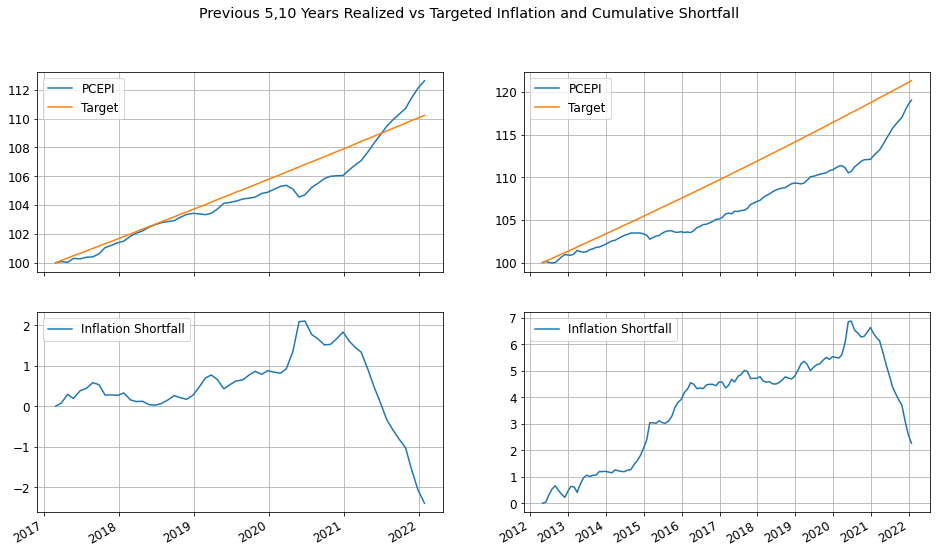

In [4]:
fig, axs = plt.subplots(nrows = 2,ncols = 2,sharex="col", figsize = (16,9))
fig.suptitle("Previous 5,10 Years Realized vs Targeted Inflation and Cumulative Shortfall")

axs[0,0].plot(fred5["PCEPI"],label = "PCEPI")
axs[0,0].plot(fred5["Target"],label = "Target")
axs[0,0].grid(True)
axs[0,0].legend(loc="upper left")
axs[1,0].plot(fred5["Shortfall"],label = "Inflation Shortfall")
axs[1,0].grid(True)
axs[1,0].legend(loc="upper left")

axs[0,1].plot(fred["PCEPI"],label = "PCEPI")
axs[0,1].plot(fred["Target"],label = "Target")
axs[0,1].grid(True)
axs[0,1].legend(loc="upper left")
axs[1,1].plot(fred["Shortfall"],label = "Inflation Shortfall")
axs[1,1].grid(True)
axs[1,1].legend(loc="upper left")

#fig.tight_layout()
fig.autofmt_xdate()
plt.show()

In [5]:
next_month = fred.index[-1]+pd.DateOffset(months=1)

#5 Year
future_index5 = pd.date_range(start = next_month, end = datetime.datetime(year=fred.index[-1].year+5, month=fred.index[-1].month, day=fred.index[-1].day), freq="MS")
future_index = pd.date_range(start = next_month, end = datetime.datetime(year=fred.index[-1].year+10, month=fred.index[-1].month, day=fred.index[-1].day), freq="MS")

target_future5 = fred5["Target"][-1]*monthly_target**60
target_future = fred["Target"][-1]*monthly_target**120

PCEPI_now5 = fred5["PCEPI"][-1]
PCEPI_now = fred["PCEPI"][-1]
necessary_rate5 = (target_future5/PCEPI_now5)**(1/60)
necessary_rate = (target_future/PCEPI_now)**(1/120)

PCEPI_necessary5 = [PCEPI_now5]
target_future_list5 = [fred5["Target"][-1]]
for i in range(1,60):
    PCEPI_necessary5.append(PCEPI_necessary5[i-1]*necessary_rate5)
    target_future_list5.append(target_future_list5[i-1]*monthly_target)

#10 Year
PCEPI_necessary = [PCEPI_now]
target_future_list = [fred["Target"][-1]]
for i in range(1,120):
    PCEPI_necessary.append(PCEPI_necessary[i-1]*necessary_rate)
    target_future_list.append(target_future_list[i-1]*monthly_target)

future_df5 = pd.DataFrame({"PCEPI":PCEPI_necessary5[1:],"Target":target_future_list5[1:]}, index = future_index5)
future_df = pd.DataFrame({"PCEPI":PCEPI_necessary[1:],"Target":target_future_list[1:]}, index = future_index)

combined_df5 = pd.concat([fred5,future_df5])
combined_df5["Shortfall"] = combined_df5["Target"] - combined_df5["PCEPI"]

combined_df = pd.concat([fred,future_df])
combined_df["Shortfall"] = combined_df["Target"] - combined_df["PCEPI"]

If we assume that the Fed will want to reach an average of 2% inflation over either the next 5 years (so 2% over 10 years) or over the next 10 years (so 2% over 20 years), we can calculate the necessary inflation rate to achieve this target. Below, I take the same data as shown above, but add 5, 10 years in which inflation is held constant such that by the end of the period the Fed has achieved an average of 2% inflation.

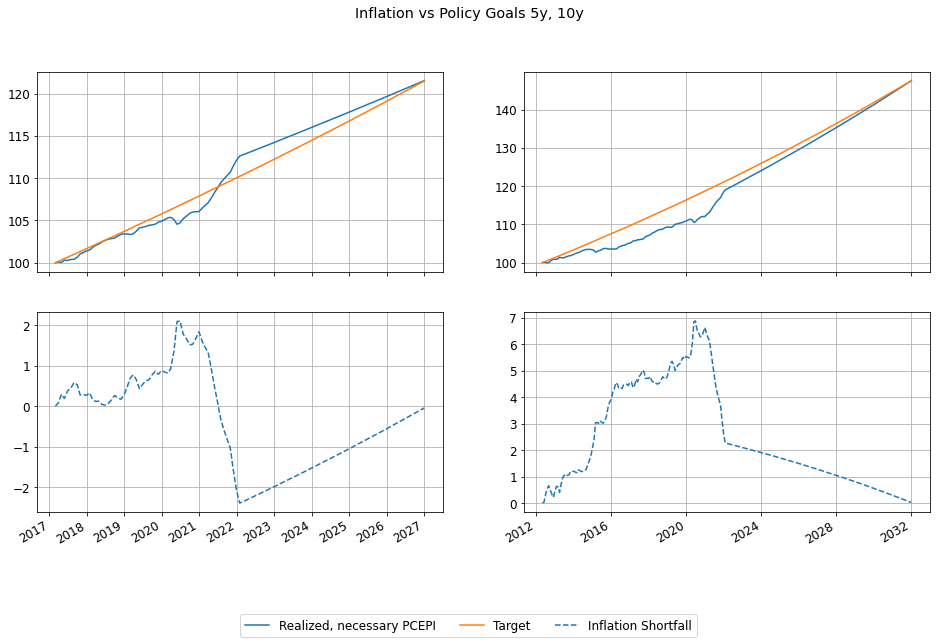

In [6]:

fig, axs = plt.subplots(nrows = 2,ncols = 2,sharex="col", figsize = (16,9))
fig.suptitle("Inflation vs Policy Goals 5y, 10y")

axs[0,0].plot(combined_df5["PCEPI"],label = "Realized, necessary PCEPI")
axs[0,0].plot(combined_df5["Target"],label = "Target")
axs[0,0].grid(True)

axs[1,0].plot(combined_df5["Shortfall"],"--", label = "Inflation Shortfall")
axs[1,0].grid(True)


axs[0,1].plot(combined_df["PCEPI"])
axs[0,1].plot(combined_df["Target"])
axs[0,1].grid(True)


axs[1,1].plot(combined_df["Shortfall"],"--")
axs[1,1].grid(True)

fig.autofmt_xdate()
fig.legend(loc='lower center', ncol = 6)
plt.show()

This raises the question: Does the market believe that the Fed will achieve the goal over the next five or even ten years? Below, I therefore add to the plot the inflation path that markets where pricing when the last PCE data came out.

At the end of February, 5yr break-evens were priced so that it seemed like the market believed the Fed would almost, but not quite achieve its goal over the next 10 years. As of end of March, markets were expecting to overshoot the Feds target over 5 years by almost as much as it was expecting to undershoot it during the height of Covid.

This is *before* we take into account recent data int the week 10th to 16th of May.

However, this is still seen as transitory. In the long run, markets still expect the Fed to fall short as implied by the 10 year breakevens.

In [7]:

combined_df5["PCEPI_Implied"] = PCEPI_now5

CEPI_implied5_loc = combined_df5.columns.get_loc("PCEPI_Implied")
last_breakeven5 = (1+fred5["T5YIE"][-1]/100)**(1/12)

for i in range(len(fred5.index),len(combined_df5.index)):
    combined_df5.iloc[i,CEPI_implied5_loc] = combined_df5.iloc[i-1,CEPI_implied5_loc]*last_breakeven5

combined_df5["PCEPI_Implied"][0:len(fred5.index)] = None
combined_df5["Implied_Shortfall"] = combined_df5["Target"] - combined_df5["PCEPI_Implied"]

combined_df["PCEPI_Implied"] = PCEPI_now

CEPI_implied_loc = combined_df.columns.get_loc("PCEPI_Implied")
last_breakeven10 = (1+fred["T10YIE"][-1]/100)**(1/12)

for i in range(len(fred.index),len(combined_df.index)):
    combined_df.iloc[i,CEPI_implied_loc] = combined_df.iloc[i-1,CEPI_implied_loc]*last_breakeven10

combined_df["PCEPI_Implied"][0:len(fred.index)] = None
combined_df["Implied_Shortfall"] = combined_df["Target"] - combined_df["PCEPI_Implied"]

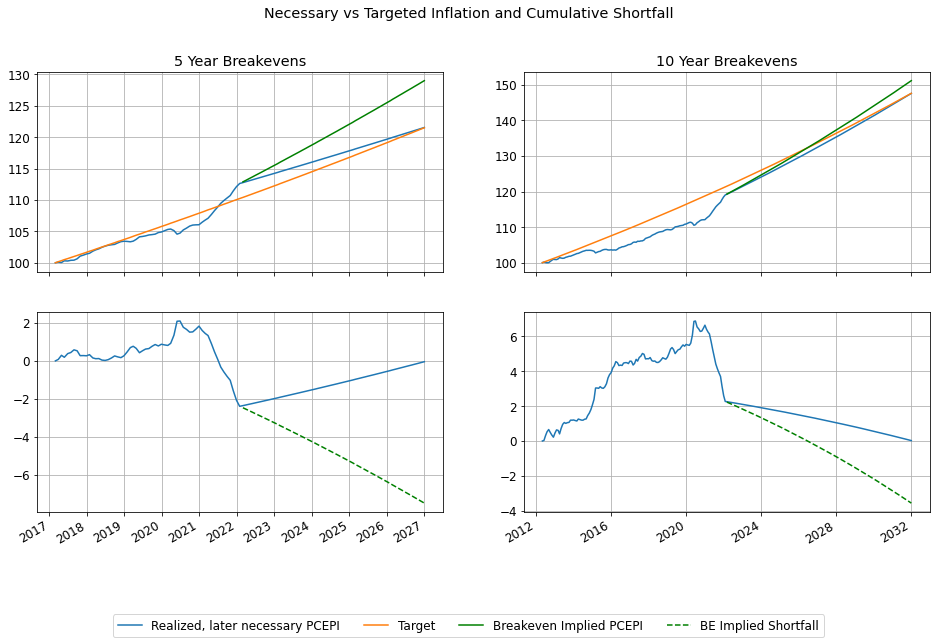

In [8]:

labels = ["Realized, later necessary PCEPI", "Target", "Breakeven Implied PCEPI", "BE Implied Shortfall"]
fig, axs = plt.subplots(nrows = 2,ncols = 2,sharex="col", figsize = (16,9))
fig.suptitle("Necessary vs Targeted Inflation and Cumulative Shortfall")
axs[0,0].set_title("5 Year Breakevens")
l1, = axs[0,0].plot(combined_df5["PCEPI"],label = "Realized, later necessary PCEPI")
l2, = axs[0,0].plot(combined_df5["Target"],label = "Target")
l3, = axs[0,0].plot(combined_df5["PCEPI_Implied"],"g")
axs[0,0].grid(True)


l4, = axs[1,0].plot(combined_df5["Shortfall"], label = "Shortfall, given target met")
l5, = axs[1,0].plot(combined_df5["Implied_Shortfall"], "--g")
axs[1,0].grid(True)

axs[0,1].set_title("10 Year Breakevens")
axs[0,1].plot(combined_df["PCEPI"],label = "Realized, later necessary PCEPI")
axs[0,1].plot(combined_df["Target"],label = "Target")
axs[0,1].plot(combined_df["PCEPI_Implied"],"g")
axs[0,1].grid(True)


axs[1,1].plot(combined_df["Shortfall"],label = "Shortfall, given target met")
axs[1,1].plot(combined_df["Implied_Shortfall"],"--g")
axs[1,1].grid(True)
fig.legend([l1,l2,l3,l5], labels, loc='lower center', ncol = 5)

fig.autofmt_xdate()
#fig.tight_layout()
plt.show()

Comparing the actually expected vs. necessary inflation numbers, we can even see that the ten year inflation expectations are not only lower than they would be if people believed the Fed would be able (or would want to) hit their inflation target, they are even lower than the five year inflation expectations.

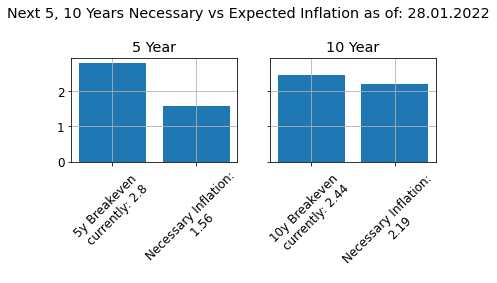

In [9]:

five_year = [fred5["T5YIE"][-1],((necessary_rate5**12)-1)*100]
ten_year = [fred["T10YIE"][-1],((necessary_rate**12)-1)*100]

fig, axs = plt.subplots(nrows = 1,ncols = 2,sharey="row")
fig.suptitle("Next 5, 10 Years Necessary vs Expected Inflation as of: "+fred.index[-1].strftime("%d.%m.%Y"))

axs[0].bar(["5y Breakeven \n"+"currently: "+str(round(five_year[0],2)),"Necessary Inflation:\n "+str(round(five_year[1],2))],five_year)
axs[0].grid(True)
axs[0].title.set_text('5 Year')

for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
axs[1].bar(["10y Breakeven \n"+"currently: "+str(round(ten_year[0],2)),"Necessary Inflation: \n"+str(round(ten_year[1],2))],ten_year)
axs[1].grid(True)
axs[1].title.set_text('10 Year')

for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)
fig.tight_layout()
plt.show()

This raises an interesting question about inflation expectations more generally. Looking at historical breakevens for five years, 10 years and the 5y5y forward implied rate, we can actually see that having lower 5 year expectations than 10 year expectations is quite a novel feature. And this difference has only changed very recently.

In [10]:
start = datetime.datetime(year=end.year-20, month=end.month, day=end.day)
symbols = ["T5YIE","T5YIFR","T10YIE"]
fred_1= pdr.DataReader(symbols, 'fred', start, end)
fred_1.to_csv("fred_1.csv")
fred = pd.read_csv("fred_1.csv", index_col = "DATE")
fred.index = pd.DatetimeIndex(fred.index)
fred["Target"] = 2
five_five_vs_five = fred["T5YIE"]-fred["T5YIFR"]


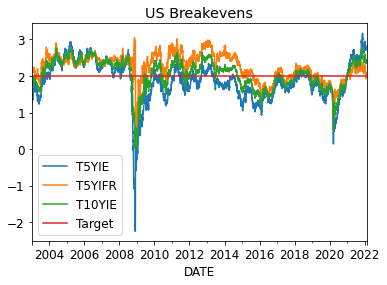

In [11]:
fred.plot(title = "US Breakevens")
plt.show()

Below, I zoom into the time since 2020. Very interestingly the difference between inflation expectations decreased as their overall level increased in H2 2020, but it was only on the 7th of January 2021, 2 days after the Georgia elections, that this relationship turned around for the first time in over 10 years.

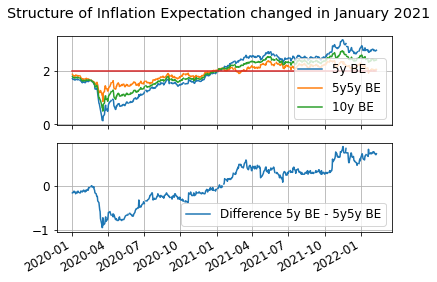

In [12]:

fig, axs = plt.subplots(2,1,sharex="col")
fig.suptitle("Structure of Inflation Expectation changed in January 2021")

axs[0].plot(fred["2020-01-01":])
axs[0].legend(labels = ["5y BE", "5y5y BE","10y BE"])
axs[1].plot(five_five_vs_five["2020-01-01":])
axs[1].legend(["Difference 5y BE - 5y5y BE"])
axs[0].grid(True)
axs[1].grid(True)
fig.autofmt_xdate()
#fig.tight_layout()
plt.show()


As one would expect, the recent increase in medium-term inflation expectations had also had its impact on Fed expectations, with a hike in June being now (actually as of 16.05., so 6 weeks after last data I used in above analysis) priced at 10%.

<https://www.cmegroup.com/trading/interest-rates/countdown-to-fomc.html>

## Repeating the analysis using PCI to get to implied PCEPI to have more timely data

In [13]:
#Download data with PDR
end = datetime.datetime.today()
start = datetime.datetime(year=end.year-10, month=end.month, day=end.day)

#Fred as standard API
symbols = ["T5YIE","T10YIE"]
fred = pdr.DataReader(symbols, 'fred', start, end)
symbols = ["PCEPI","CPIAUCSL"]
inflation_index = pdr.DataReader(symbols, 'fred', start, end)

In [14]:

inflation_mom = inflation_index.pct_change()
inflation_mom.tail()

,PCEPI,CPIAUCSL
DATE,,
2021-09-01,0.003465,0.004109
2021-10-01,0.006487,0.008665
2021-11-01,0.006266,0.006992
2021-12-01,0.004476,0.005752
2022-01-01,0.000000,0.006451


In [15]:
inflation_mom = inflation_index.pct_change()
inflation_mom.tail()["PCEPI"].iloc[-1]*100

0.0

In [16]:
X = inflation_mom["CPIAUCSL"]
X = sm.add_constant(X)
model = sm.OLS(endog = inflation_mom["PCEPI"], exog = X, missing="drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PCEPI   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     661.1
Date:                Thu, 10 Feb 2022   Prob (F-statistic):           9.86e-50
Time:                        18:49:47   Log-Likelihood:                 684.49
No. Observations:                 118   AIC:                            -1365.
Df Residuals:                     116   BIC:                            -1359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   8.24e-05      3.420      0.001       0.000       0.000
CPIAUCSL       0.6749      0.026     25.712      0.000       0.623       0.727
==============================================================================
Omnibus:                       71.943   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              767.207
Skew:                          -1.740   Prob(JB):                    2.53e-167
Kurtosis:                      14.997   Cond. No.                         386.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model.fittedvalues.tail()*100

DATE
2021-09-01    0.305452
2021-10-01    0.612944
2021-11-01    0.500073
2021-12-01    0.416351
2022-01-01    0.463520
Freq: MS, dtype: float64

In [18]:
pci_implied_cepi_mom = model.params["const"]+model.params["CPIAUCSL"]*inflation_mom["CPIAUCSL"]

In [19]:
pci_implied_pcepi = pd.DataFrame({"PCI Implied CEPI":100*(pci_implied_cepi_mom+1).cumprod()})

pci_implied_pcepi.index = pci_implied_pcepi.index + pd.offsets.MonthEnd(0)+pd.offsets.BusinessDay(n = 8)
fred = pd.concat([fred, pci_implied_pcepi], axis = 1)

#Cleanse Data
fred.index = pd.DatetimeIndex(fred.index)
fred[["T5YIE","T10YIE"]] = fred[["T5YIE","T10YIE"]].interpolate(method = "linear")
fred = fred.dropna()
print("Last data point for:" +str(fred.index[-1]))


Last data point for:2022-02-10 00:00:00


In [20]:

monthly_target = 1.02**(1/12)

#5 Years
fred5 = fred[["PCI Implied CEPI","T5YIE"]].tail(60)
fred5["Target"] = 100

target5_loc = fred5.columns.get_loc("Target")
for i in range(1,len(fred5.index)):
    fred5.iloc[i,target5_loc] = fred5.iloc[i-1,target5_loc]*monthly_target

fred5["PCI Implied CEPI"] = 100* fred5["PCI Implied CEPI"]/fred5["PCI Implied CEPI"][0]
fred5["Shortfall"] = fred5["Target"] - fred5["PCI Implied CEPI"]

fred["Target"] = 100
#10 Years
target_loc = fred.columns.get_loc("Target")
for i in range(1,len(fred.index)):
    fred.iloc[i,target_loc] = fred.iloc[i-1,target_loc]*monthly_target

fred["PCI Implied CEPI"] = 100* fred["PCI Implied CEPI"]/fred["PCI Implied CEPI"][0]
fred["Shortfall"] = fred["Target"] - fred["PCI Implied CEPI"]

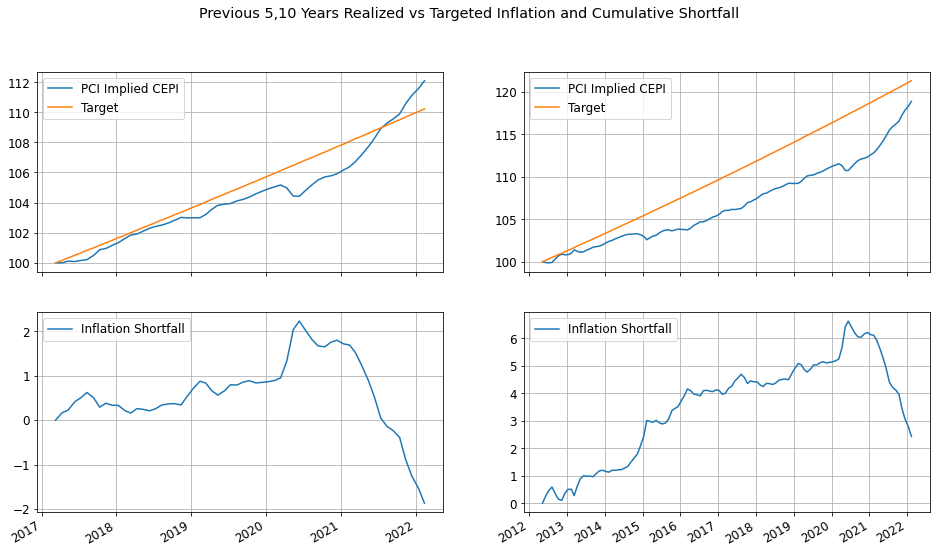

In [21]:
fig, axs = plt.subplots(nrows = 2,ncols = 2,sharex="col", figsize = (16,9))
fig.suptitle("Previous 5,10 Years Realized vs Targeted Inflation and Cumulative Shortfall")

axs[0,0].plot(fred5["PCI Implied CEPI"],label = "PCI Implied CEPI")
axs[0,0].plot(fred5["Target"],label = "Target")
axs[0,0].grid(True)
axs[0,0].legend(loc="upper left")
axs[1,0].plot(fred5["Shortfall"],label = "Inflation Shortfall")
axs[1,0].grid(True)
axs[1,0].legend(loc="upper left")

axs[0,1].plot(fred["PCI Implied CEPI"],label = "PCI Implied CEPI")
axs[0,1].plot(fred["Target"],label = "Target")
axs[0,1].grid(True)
axs[0,1].legend(loc="upper left")
axs[1,1].plot(fred["Shortfall"],label = "Inflation Shortfall")
axs[1,1].grid(True)
axs[1,1].legend(loc="upper left")

#fig.tight_layout()
fig.autofmt_xdate()
plt.show()

In [22]:
next_month = fred.index[-1]+pd.DateOffset(months=1)

#5 Year
future_index5 = pd.date_range(start = next_month, end = datetime.datetime(year=fred.index[-1].year+5, month=fred.index[-1].month, day=fred.index[-1].day), freq="MS")
future_index = pd.date_range(start = next_month, end = datetime.datetime(year=fred.index[-1].year+10, month=fred.index[-1].month, day=fred.index[-1].day), freq="MS")

target_future5 = fred5["Target"][-1]*monthly_target**60
target_future = fred["Target"][-1]*monthly_target**120

PCEPI_now5 = fred5["PCI Implied CEPI"][-1]
PCEPI_now = fred["PCI Implied CEPI"][-1]
necessary_rate5 = (target_future5/PCEPI_now5)**(1/60)
necessary_rate = (target_future/PCEPI_now)**(1/120)

PCEPI_necessary5 = [PCEPI_now5]
target_future_list5 = [fred5["Target"][-1]]
for i in range(1,60):
    PCEPI_necessary5.append(PCEPI_necessary5[i-1]*necessary_rate5)
    target_future_list5.append(target_future_list5[i-1]*monthly_target)

#10 Year
PCEPI_necessary = [PCEPI_now]
target_future_list = [fred["Target"][-1]]
for i in range(1,120):
    PCEPI_necessary.append(PCEPI_necessary[i-1]*necessary_rate)
    target_future_list.append(target_future_list[i-1]*monthly_target)

future_df5 = pd.DataFrame({"PCI Implied CEPI":PCEPI_necessary5[1:],"Target":target_future_list5[1:]}, index = future_index5)
future_df = pd.DataFrame({"PCI Implied CEPI":PCEPI_necessary[1:],"Target":target_future_list[1:]}, index = future_index)

combined_df5 = pd.concat([fred5,future_df5])
combined_df5["Shortfall"] = combined_df5["Target"] - combined_df5["PCI Implied CEPI"]

combined_df = pd.concat([fred,future_df])
combined_df["Shortfall"] = combined_df["Target"] - combined_df["PCI Implied CEPI"]

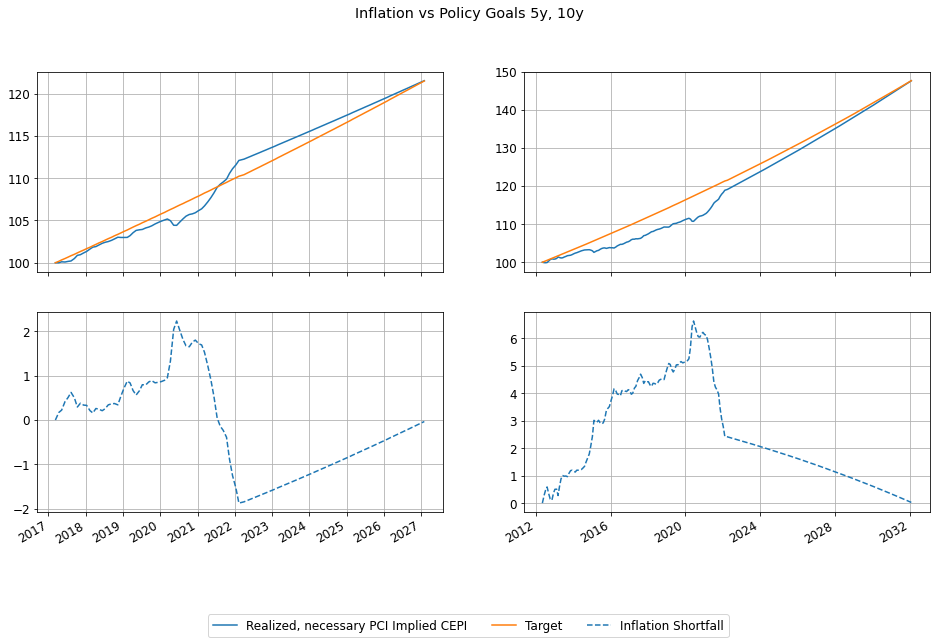

In [23]:

fig, axs = plt.subplots(nrows = 2,ncols = 2,sharex="col", figsize = (16,9))
fig.suptitle("Inflation vs Policy Goals 5y, 10y")

axs[0,0].plot(combined_df5["PCI Implied CEPI"],label = "Realized, necessary PCI Implied CEPI")
axs[0,0].plot(combined_df5["Target"],label = "Target")
axs[0,0].grid(True)

axs[1,0].plot(combined_df5["Shortfall"],"--", label = "Inflation Shortfall")
axs[1,0].grid(True)


axs[0,1].plot(combined_df["PCI Implied CEPI"])
axs[0,1].plot(combined_df["Target"])
axs[0,1].grid(True)


axs[1,1].plot(combined_df["Shortfall"],"--")
axs[1,1].grid(True)

fig.autofmt_xdate()
fig.legend(loc='lower center', ncol = 6)
plt.show()

In [24]:

combined_df5["PCI Implied CEPI_Implied"] = PCEPI_now5

CEPI_implied5_loc = combined_df5.columns.get_loc("PCI Implied CEPI_Implied")
last_breakeven5 = (1+fred5["T5YIE"][-1]/100)**(1/12)

for i in range(len(fred5.index),len(combined_df5.index)):
    combined_df5.iloc[i,CEPI_implied5_loc] = combined_df5.iloc[i-1,CEPI_implied5_loc]*last_breakeven5

combined_df5["PCI Implied CEPI_Implied"][0:len(fred5.index)] = None
combined_df5["Implied_Shortfall"] = combined_df5["Target"] - combined_df5["PCI Implied CEPI_Implied"]

combined_df["PCI Implied CEPI_Implied"] = PCEPI_now

CEPI_implied_loc = combined_df.columns.get_loc("PCI Implied CEPI_Implied")
last_breakeven10 = (1+fred["T10YIE"][-1]/100)**(1/12)

for i in range(len(fred.index),len(combined_df.index)):
    combined_df.iloc[i,CEPI_implied_loc] = combined_df.iloc[i-1,CEPI_implied_loc]*last_breakeven10

combined_df["PCI Implied CEPI_Implied"][0:len(fred.index)] = None
combined_df["Implied_Shortfall"] = combined_df["Target"] - combined_df["PCI Implied CEPI_Implied"]

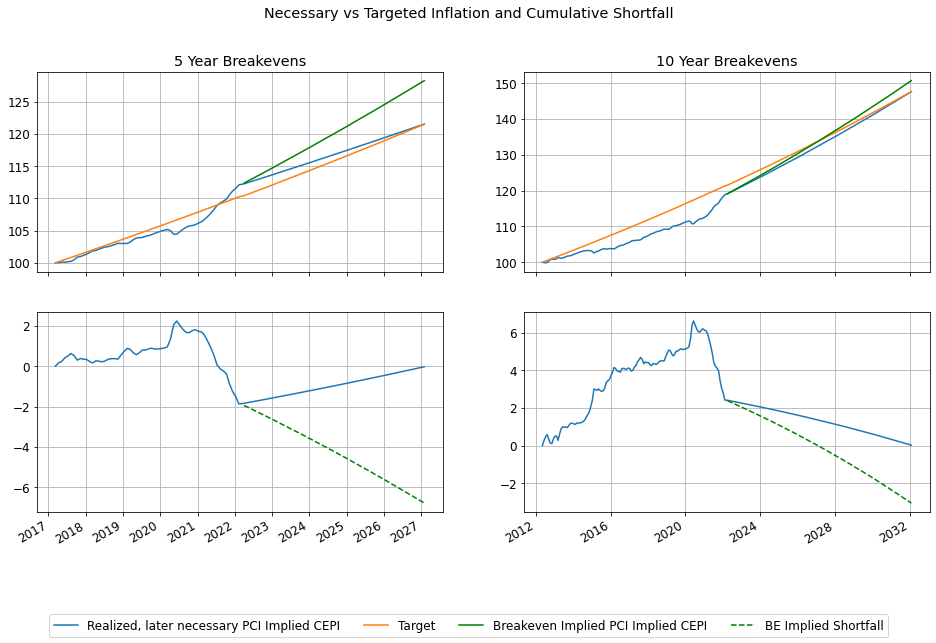

In [25]:

labels = ["Realized, later necessary PCI Implied CEPI", "Target", "Breakeven Implied PCI Implied CEPI", "BE Implied Shortfall"]
fig, axs = plt.subplots(nrows = 2,ncols = 2,sharex="col", figsize = (16,9))
fig.suptitle("Necessary vs Targeted Inflation and Cumulative Shortfall")
axs[0,0].set_title("5 Year Breakevens")
l1, = axs[0,0].plot(combined_df5["PCI Implied CEPI"],label = "Realized, later necessary PCI Implied CEPI")
l2, = axs[0,0].plot(combined_df5["Target"],label = "Target")
l3, = axs[0,0].plot(combined_df5["PCI Implied CEPI_Implied"],"g")
axs[0,0].grid(True)


l4, = axs[1,0].plot(combined_df5["Shortfall"], label = "Shortfall, given target met")
l5, = axs[1,0].plot(combined_df5["Implied_Shortfall"], "--g")
axs[1,0].grid(True)

axs[0,1].set_title("10 Year Breakevens")
axs[0,1].plot(combined_df["PCI Implied CEPI"],label = "Realized, later necessary PCI Implied CEPI")
axs[0,1].plot(combined_df["Target"],label = "Target")
axs[0,1].plot(combined_df["PCI Implied CEPI_Implied"],"g")
axs[0,1].grid(True)


axs[1,1].plot(combined_df["Shortfall"],label = "Shortfall, given target met")
axs[1,1].plot(combined_df["Implied_Shortfall"],"--g")
axs[1,1].grid(True)
fig.legend([l1,l2,l3,l5], labels, loc='lower center', ncol = 5)

fig.autofmt_xdate()
#fig.tight_layout()
plt.show()

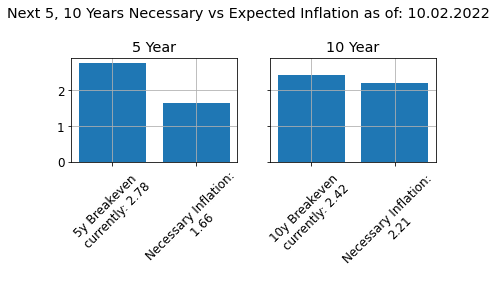

In [26]:

five_year = [fred5["T5YIE"][-1],((necessary_rate5**12)-1)*100]
ten_year = [fred["T10YIE"][-1],((necessary_rate**12)-1)*100]

fig, axs = plt.subplots(nrows = 1,ncols = 2,sharey="row")
fig.suptitle("Next 5, 10 Years Necessary vs Expected Inflation as of: "+fred.index[-1].strftime("%d.%m.%Y"))

axs[0].bar(["5y Breakeven \n"+"currently: "+str(round(five_year[0],2)),"Necessary Inflation:\n "+str(round(five_year[1],2))],five_year)
axs[0].grid(True)
axs[0].title.set_text('5 Year')

for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
axs[1].bar(["10y Breakeven \n"+"currently: "+str(round(ten_year[0],2)),"Necessary Inflation: \n"+str(round(ten_year[1],2))],ten_year)
axs[1].grid(True)
axs[1].title.set_text('10 Year')

for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)
fig.tight_layout()
plt.show()